# FGSM

https://www.tensorflow.org/tutorials/generative/adversarial_fgsm

In [1]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

# Helper function to preprocess the image so that it can be inputted in MobileNetV2
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

# Helper function to extract the least likely label from probability vector
def get_least_likely_imagenet_label(probs):
  return decode_predictions(probs, top=1000)[0][999]

14540800/14536120 [==============================] - 0s 0us/step


The following helped understand how to use numpy to set up an image for adversarial attack

In [2]:
import cv2
import numpy as np
x = cv2.imread('YellowLabradorLooking_new.jpg')
x = np.flip(x, axis=2)

Original image processing using tensorflow

40960/35363 [==================================] - 0s 0us/step


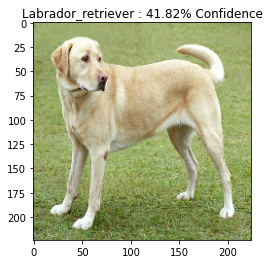

In [3]:
image_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)


plt.figure()
plt.imshow(image[0]*0.5+0.5) # To change [-1, 1] to [0,1]
_, image_class, class_confidence = get_imagenet_label(image_probs)

plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

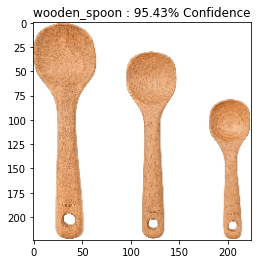

In [115]:
import cv2
image = cv2.imread('wooden spoon910.jpg')
image = np.flip(image, axis=2)

image = preprocess(image)
image_probs = pretrained_model.predict(image)


plt.figure()
plt.imshow(image[0]*0.5+0.5) # To change [-1, 1] to [0,1]
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

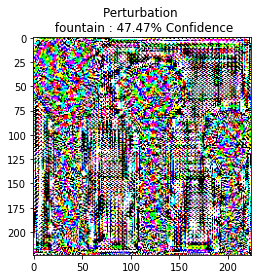

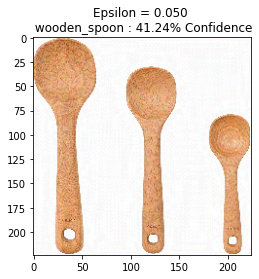

In [117]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)


  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

# Get the input label of the image.
label_index = 910
label = tf.one_hot(label_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
#print(perturbations[0].shape)
_, pertLabel, pertConfidence = get_imagenet_label(pretrained_model.predict(perturbations))
plt.title('{} \n {} : {:.2f}% Confidence'.format('Perturbation', pertLabel, pertConfidence*100))
plt.imshow(perturbations[0]*0.5+0.5); # To change [-1, 1] to [0,1]

def display_images(image, description):
  _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
  plt.show()

  
epsilons = [0, 0.01, 0.05, 0.1, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  if(eps == .05):
    adv_x = image + eps*perturbations
    adv_x = tf.clip_by_value(adv_x, -1, 1)
    display_images(adv_x, descriptions[i])

Using a random perturbation of the correct size, could also think about using a random label instead of the correct one

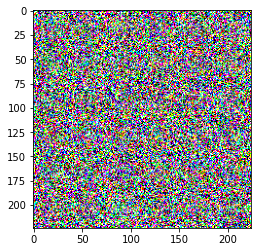

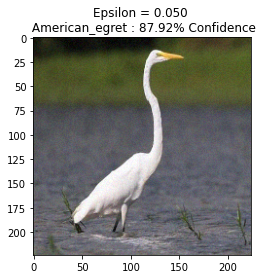

In [54]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

# def create_adversarial_pattern(input_image, input_label):
#   with tf.GradientTape() as tape:
#     tape.watch(input_image)
#     prediction = pretrained_model(input_image)
#     loss = loss_object(input_label, prediction)

#   # Get the gradients of the loss w.r.t to the input image.
#   gradient = tape.gradient(loss, input_image)
#   # Get the sign of the gradients to create the perturbation
#   signed_grad = tf.sign(gradient)
#   return signed_grad

# Get the input label of the image.
labrador_retriever_index = 208
label = tf.one_hot(labrador_retriever_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

#perturbations = create_adversarial_pattern(image, label)
#print(perturbations)
#plt.imshow(perturbations[0]*0.5+0.5); # To change [-1, 1] to [0,1]

pert = np.random.randint(2, size=image.shape) #create a random perturbation the same size
pert = (pert-0.5)*2
#print(pert)
plt.imshow(pert[0]*0.5+0.5); # To change [-1, 1] to [0,1]

def display_images(image, description):
  _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
  plt.show()

  
epsilons = [0, 0.01, 0.05, 0.1, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  if(eps == .05):
    adv_x = image + eps*pert
    adv_x = tf.clip_by_value(adv_x, -1, 1)
    display_images(adv_x, descriptions[i])

# Second Implementation

https://medium.com/analytics-vidhya/implementing-adversarial-attacks-and-defenses-in-keras-tensorflow-2-0-cab6120c5715

In [23]:
import tensorflow as tf

from tensorflow.keras.datasets import mnist, cifar10, cifar100

from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation

import numpy as np
import random

import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = mnist.load_data()

labels = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']


11493376/11490434 [==============================] - 0s 0us/step


1) Process the data, normalize it, reshape it, and one-hot-encode the labels

In [24]:

img_rows, img_cols, channels = 28, 28, 1
num_classes = 10

x_train = x_train / 255
x_test = x_test / 255

x_train = x_train.reshape((-1, img_rows, img_cols, channels))
x_test = x_test.reshape((-1, img_rows, img_cols, channels))

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

print("Data shapes", x_test.shape, y_test.shape, x_train.shape, y_train.shape)

Data shapes (10000, 28, 28, 1) (10000, 10) (60000, 28, 28, 1) (60000, 10)


2) Setup the model

In [25]:
def create_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu', input_shape=(img_rows, img_cols, channels)))
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(32))
    model.add(Dropout(0.2))
    model.add(Dense(32))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    
    return model

model = create_model()

3) And finally, fit the model

In [26]:
model.fit(x_train, y_train,
          batch_size=32,
          epochs=20,
          validation_data=(x_test, y_test))

print("Base accuracy on regular images:", model.evaluate(x=x_test, y=y_test, verbose=0))

Epoch 1/20
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0337 - accuracy: 0.7476 - val_loss: 0.0065 - val_accuracy: 0.9563
Epoch 2/20
1875/1875 [==============================] - 14s 8ms/step - loss: 0.0100 - accuracy: 0.9353 - val_loss: 0.0049 - val_accuracy: 0.9683
Epoch 3/20
1875/1875 [==============================] - 14s 8ms/step - loss: 0.0080 - accuracy: 0.9483 - val_loss: 0.0043 - val_accuracy: 0.9727
Epoch 4/20
1875/1875 [==============================] - 14s 8ms/step - loss: 0.0065 - accuracy: 0.9580 - val_loss: 0.0040 - val_accuracy: 0.9733
Epoch 5/20
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0061 - accuracy: 0.9610 - val_loss: 0.0038 - val_accuracy: 0.9752
Epoch 6/20
1875/1875 [==============================] - 14s 8ms/step - loss: 0.0054 - accuracy: 0.9653 - val_loss: 0.0032 - val_accuracy: 0.9790
Epoch 7/20
1875/1875 [==============================] - 14s 8ms/step - loss: 0.0050 - accuracy: 0.9678 - val_loss: 0.0036 - val_ac

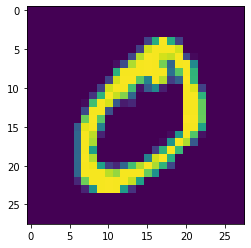

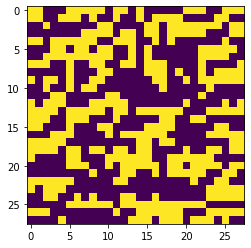

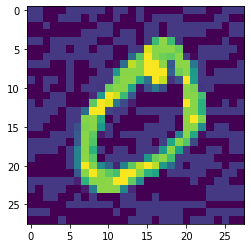

zero
zero


In [27]:
def adversarial_pattern(image, label):
    image = tf.cast(image, tf.float32)
    
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.MSE(label, prediction)
    
    gradient = tape.gradient(loss, image)
    
    signed_grad = tf.sign(gradient)
    
    return signed_grad


image = x_train[1]
image_label = y_train[1]
plt.imshow(image.reshape((img_rows, img_cols)))
plt.show()

perturbations = adversarial_pattern(image.reshape((1, img_rows, img_cols, channels)), image_label).numpy()
plt.imshow(perturbations[0].reshape((img_rows, img_cols)))
plt.show()
adversarial = image + perturbations * 0.1



if channels == 1:
    plt.imshow(adversarial.reshape((img_rows, img_cols)))
else:
    plt.imshow(adversarial.reshape((img_rows, img_cols, channels)))
plt.show()

print(labels[model.predict(image.reshape((1, img_rows, img_cols, channels))).argmax()])
print(labels[model.predict(adversarial).argmax()])

In [17]:
# import glob
# import matplotlib
# from matplotlib import pyplot as plt
# import matplotlib.image as mpimg
# import numpy as np
# import imageio as im

# from keras.models import Sequential
# from keras.layers import Conv2D
# from keras.layers import MaxPooling2D
# from keras.layers import Flatten
# from keras.layers import Dense
# from keras.layers import Dropout
# from keras.preprocessing import image
# from keras.preprocessing.image import ImageDataGenerator
# from keras.callbacks import ModelCheckpoint

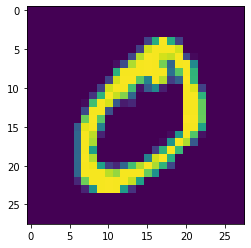

In [31]:
from keras import models

img = x_train[1]
img_tensor = img.reshape((1, img_rows, img_cols, channels))
plt.imshow(img.reshape((img_rows, img_cols)))
plt.show()


# Extracts the outputs of the top 12 layers
layer_outputs = [layer.output for layer in model.layers[:11]] 
# Creates a model that will return these outputs, given the model input
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

# Returns a list of five Numpy arrays: one array per layer activation
activations = activation_model.predict(img_tensor) 


(1, 10, 10, 32)


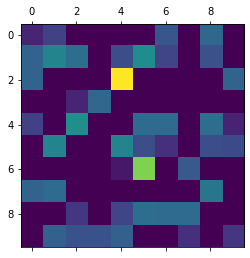

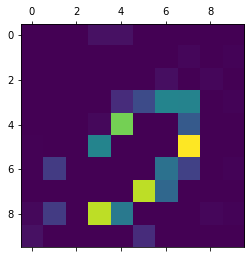

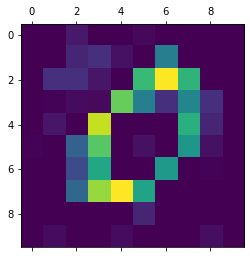

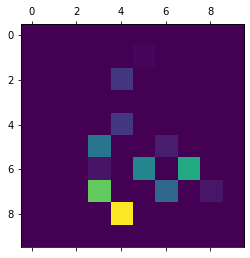

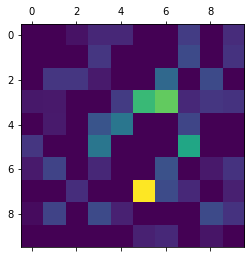

In [37]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

for i in range(5):
  plt.matshow(first_layer_activation[0, :, :, i], cmap='viridis')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


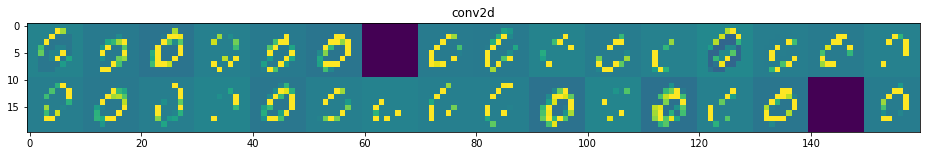

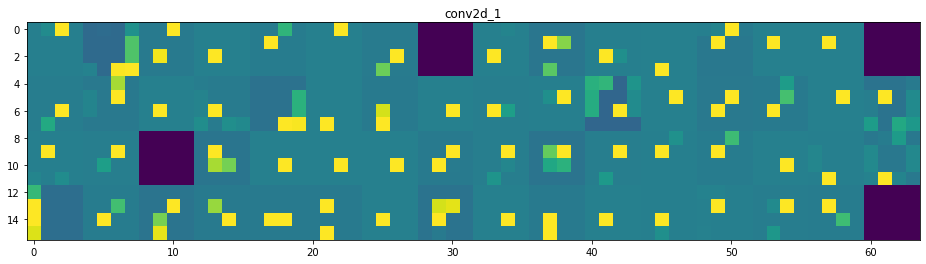

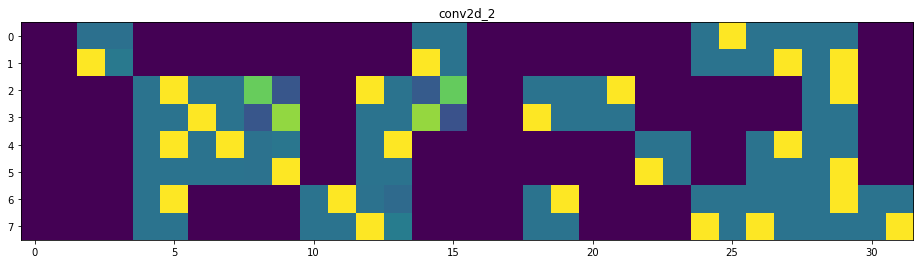

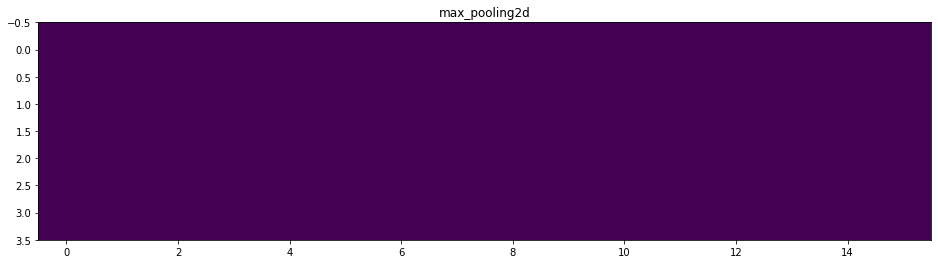

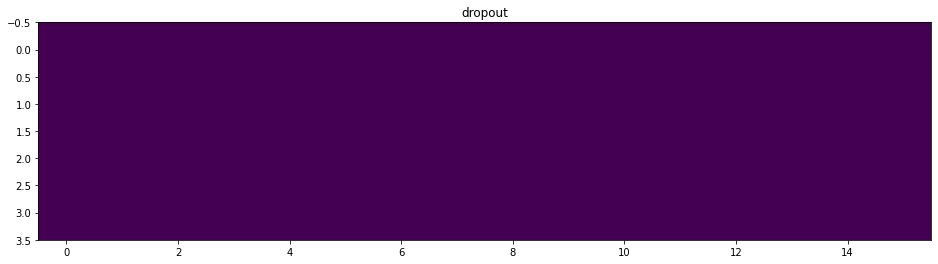

In [33]:
layer_names = []
for layer in model.layers[:5]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')


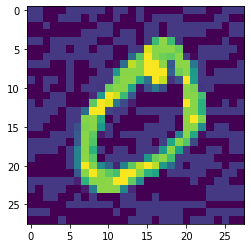

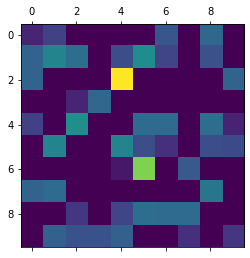

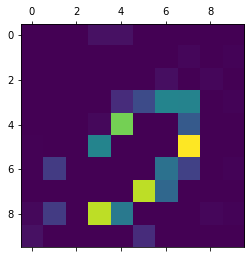

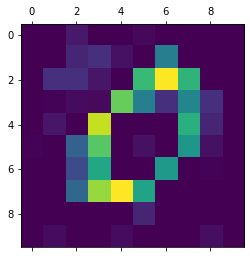

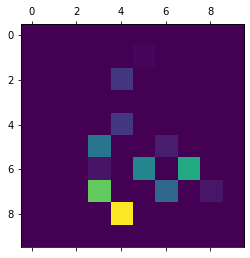

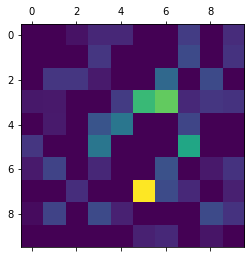

In [34]:
img = adversarial
img_tensor = img.reshape((1, img_rows, img_cols, channels))
plt.imshow(img.reshape((img_rows, img_cols)))
plt.show()


# Extracts the outputs of the top 12 layers
layer_outputs = [layer.output for layer in model.layers[:11]] 
# Creates a model that will return these outputs, given the model input
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

# Returns a list of five Numpy arrays: one array per layer activation
activations = activation_model.predict(img_tensor) 

first_layer_activation = activations[0]

for i in range(5):
  plt.matshow(first_layer_activation[0, :, :, i], cmap='viridis')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


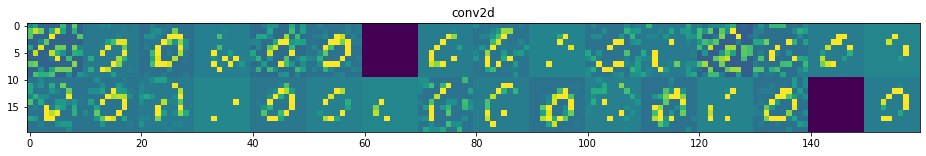

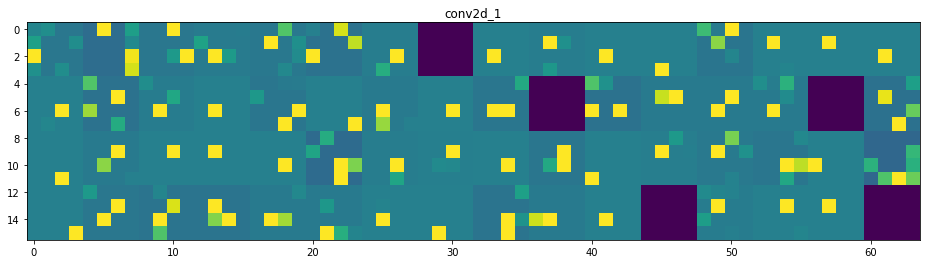

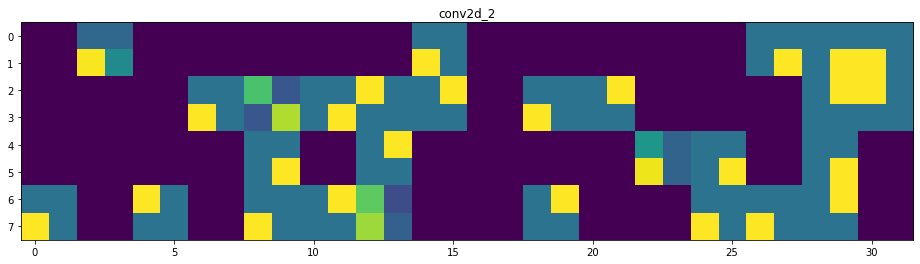

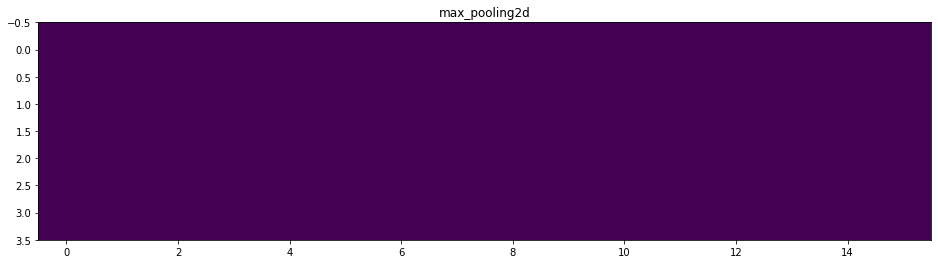

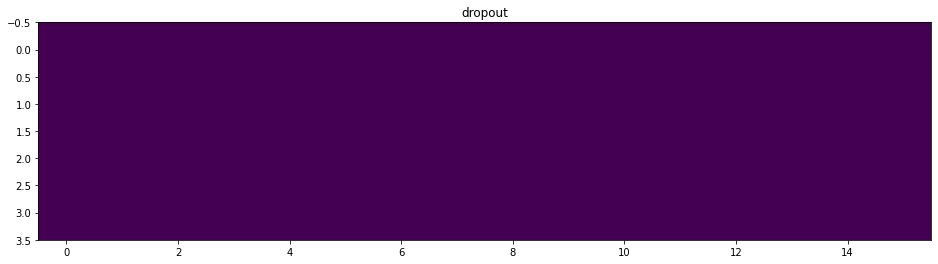

In [35]:
layer_names = []
for layer in model.layers[:5]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
